In [2]:
import json
data = sc.textFile('hdfs://master:54310/test3'). \
    map(lambda x: json.loads(x))

In [3]:
data.take(1)[0].keys()

dict_keys(['Id', 'Features', 'Labels'])

In [4]:
labels = data.map(lambda doc: doc['Labels'])

In [5]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('russian')

In [6]:
label_count = labels.flatMap(lambda l: l). \
    map(lambda l: (l,1)). \
    reduceByKey(lambda a, b: a+b). \
    collectAsMap()

In [7]:
from collections import Counter
words_from_labels = labels.flatMap(lambda labels: [(i,i.split(' ')) for i in labels]). \
    flatMap(lambda doc: [(stemmer.stem(i),[doc[0]]) for i in doc[1]]). \
    reduceByKey(lambda l1,l2: l1+l2). \
    filter(lambda x: len(set(x[1]))>1). \
    map(lambda x: (x[0],Counter(x[1]))). \
    zipWithIndex()

In [8]:
words_from_labels.count()

175

In [9]:
words_from_labels.filter(lambda x: 20 < x[1] <= 29).take(10)

[(('карт', Counter({'карты': 124, 'карта': 37})), 21),
 (('под',
   Counter({'разработка под android': 958, 'разработка под ios': 939, 'разработка под windows phone': 220, 'разработка под windows': 136, 'разработка под e-commerce': 87, 'разработка под tizen': 52})),
  22),
 (('карьер', Counter({'карьера': 84, 'карьера в it-индустрии': 62})), 23),
 (('защит', Counter({'защита': 91, 'защита информации': 53})), 24),
 (('droider', Counter({'droider chart': 80, 'droider': 68})), 25),
 (('книг', Counter({'книги': 183, 'электронные книги': 134, 'книга': 61})),
  26),
 (('процессор', Counter({'процессоры': 80, 'процессор': 46})), 27),
 (('сообществ',
   Counter({'социальные сети и сообщества': 368, 'сообщество': 37, 'сообщества': 34})),
  28),
 (('stor', Counter({'app store': 161, 'windows store': 61})), 29)]

In [215]:
import re

In [217]:
with open('/home/hadoop/data/sets_of_labels.txt', 'w+') as fp:
    for i in words_from_labels.collect():
        line = json.dumps(i, ensure_ascii=False)
        line = re.sub("[\[\]\{\}\"]", " ", line)
        line = re.sub("\s+", " ", line)
        fp.write(line+'\n\n')

In [10]:
from collections import defaultdict

In [11]:
lable_repl = defaultdict(set)

In [12]:
with open('/home/hadoop/data/label_repl.txt', 'r') as fp:
    for line in fp:
        words = line.strip().split(',')
        lable_repl[words[0]] = lable_repl[words[0]].union(set(words[1:]))

In [11]:
[(k,v) for k,v in lable_repl.items() if len(v) > 1][:10]

[('windows',
  {'vista', 'windows 7', 'windows 8', 'windows vista', 'windows xp'}),
 ('windows phone',
  {'windows phone 7', 'windows phone 8', 'разработка под windows phone'}),
 ('роботы', {'робот', 'робототехника'}),
 ('телефоны', {'мобильные телефоны', 'телефон'}),
 ('офисы', {'офис', 'офисы it-компаний'}),
 ('ruby on rails', {'rails', 'ruby'}),
 ('мобильная разработка',
  {'mobile development', 'разработка мобильных приложений'}),
 ('облако', {'cloud', 'clouds', 'облака'}),
 ('сделай сам', {'diy', 'diy или сделай сам'}),
 ('linux', {'настройка linux', 'настройка линуxи', 'настройка линух'})]

In [13]:
all_v = set()
i = 0
for k,vs in lable_repl.items():
    for v in vs:
        all_v.add(v)
        i+=1
len(all_v),i

(130, 130)

In [14]:
len(lable_repl)

103

In [15]:
lable_repl_inv = {}

In [16]:
for l, ls_to_repl in lable_repl.items():
    for repl_l in ls_to_repl:
        lable_repl_inv[repl_l] = l

In [17]:
len(lable_repl_inv)

130

In [18]:
def replace_labels(obj: dict):
    new_labels = []
    for old_l in obj['Labels']:
        if old_l in lable_repl_inv:
            new_labels.append(lable_repl_inv[old_l])
        else:
            new_labels.append(old_l)
    obj['Labels'] = list(set(new_labels))
    return obj

In [19]:
data.take(1)[0].keys()

dict_keys(['Id', 'Features', 'Labels'])

In [20]:
lables_lengths_after_repl = data.map(replace_labels). \
    map(lambda x: len(x['Labels'])).collect()
lables_lengths_before_repl = data.map(lambda x: len(x['Labels'])). \
    collect()

In [21]:
print(data.map(replace_labels). \
    flatMap(lambda x: x['Labels']). \
    distinct(). \
    count())
print(data.flatMap(lambda x: x['Labels']). \
    distinct(). \
    count())

878
1000


In [21]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set()
%matplotlib inline

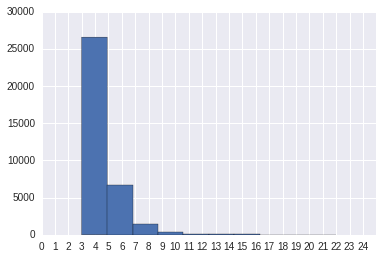

In [22]:
plt.hist(lables_lengths_before_repl)
plt.xticks(range(25))
plt.show()

In [23]:
Counter(lables_lengths_before_repl)

Counter({3: 16977, 4: 9593, 5: 4538, 6: 2108, 7: 914, 8: 538, 9: 233, 10: 142, 11: 86, 14: 42, 15: 40, 16: 34, 12: 28, 17: 21, 13: 15, 18: 15, 19: 3, 20: 1, 21: 1, 22: 1})

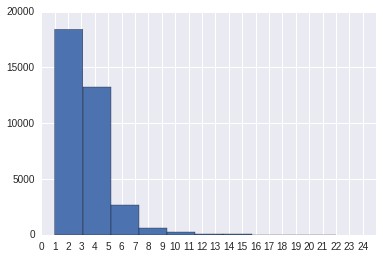

In [24]:
plt.hist(lables_lengths_after_repl)
plt.xticks(range(25))
plt.show()

In [25]:
Counter(lables_lengths_after_repl)

Counter({3: 16832, 4: 9132, 5: 4126, 6: 1891, 2: 1547, 7: 789, 8: 406, 9: 206, 10: 127, 11: 86, 13: 66, 15: 28, 14: 27, 1: 26, 16: 19, 12: 13, 17: 6, 18: 1, 21: 1, 22: 1})

In [22]:
data.map(replace_labels). \
    map(json.dumps). \
    repartition(4). \
    saveAsTextFile('hdfs://master:54310/new_lables3')

In [111]:
label_idx = labels.flatMap(lambda ls: list(set([stemmer.stem(l) for l in ls]))). \
    distinct(). \
    zipWithIndex(). \
    collectAsMap()

In [141]:
from pyspark.mllib.fpm import FPGrowth

for_train = labels.map(lambda ls: list(sorted(set([label_idx[stemmer.stem(l)] for l in ls]))))
model = FPGrowth.train(for_train,minSupport=0.0)
result = model.freqItemsets().collect()
#for fi in result:
#    print(fi)

In [ ]:
freqs = model.freqItemsets(). \
    map(lambda fi: ' '.join(map(str, sorted(fi.items)))). \
    distinct(). \
    map(lambda s: len(s.split(' '))).countByValue()

In [177]:
freqs_by_freqs = model.freqItemsets(). \
    repartition(24). \
    map(lambda fi: fi.freq). \
    countByValue()

In [179]:
idx_label = dict([(v,k) for k,v in label_idx.items()])

In [186]:
top_fi = model.freqItemsets(). \
    filter(lambda fi: fi.freq > 150 and len(fi.items) > 1). \
    map(lambda fi: (fi.freq, [idx_label[idx] for idx in fi.items])). \
    sortBy(lambda x: x[0], ascending=False).collect()

In [220]:
print(len(top_fi))
v = [t for t in top_fi if len(t[1]) == 2]
len(v),v

188


(123,
 [(1042, ['настройка линуx', 'linux']),
  (916, ['javascript', 'веб-разработк']),
  (712, ['разработка под андроид', 'android']),
  (546, ['разработка под иос', 'ios']),
  (525, ['css', 'html']),
  (521, ['css', 'веб-разработк']),
  (519, ['c#', '.net']),
  (517, ['php', 'веб-разработк']),
  (509, ['html', 'веб-разработк']),
  (436, ['ios', 'android']),
  (431, ['веб-дизайн', 'веб-разработк']),
  (429, ['iphon', 'appl']),
  (418, ['разработк', 'программирован']),
  (406, ['ubunt', 'настройка линуx']),
  (401, ['безопасн', 'информационная безопасн']),
  (400, ['html', 'javascript']),
  (336, ['c++', 'программирован']),
  (324, ['разработка мобильных приложен', 'android']),
  (307, ['ubunt', 'linux']),
  (302, ['разработка под иос', 'разработка мобильных приложен']),
  (291, ['jquer', 'веб-разработк']),
  (291, ['css', 'javascript']),
  (288, ['веб-дизайн', 'css']),
  (287, ['googl', 'android']),
  (285, ['jquer', 'javascript']),
  (282, ['разработка мобильных приложен', 'ios']),
 

In [222]:
with open()

[]